In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from compressai.entropy_models import EntropyBottleneck

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Compression Model with CompressAI's EntropyBottleneck
class CompressionModel(nn.Module):
    def __init__(self, latent_dim=128):
        super(CompressionModel, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # [1,28,28] -> [64,14,14]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [64,14,14] -> [64,7,7]
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # [64,7,7] -> [128,7,7]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),  # [128,7,7] -> [6272]
            nn.Linear(128 * 7 * 7, latent_dim)  # [6272] -> [128]
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),  # [128] -> [6272]
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)),  # [6272] -> [128,7,7]
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # [128,7,7] -> [64,14,14]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),  # [64,14,14] -> [1,28,28]
            nn.Sigmoid()  # Ensures output is in [0,1]
        )
        
        # CompressAI's EntropyBottleneck for the latent vector
        self.entropy_bottleneck = EntropyBottleneck(channels=latent_dim)
        self.entropy_bottleneck.to(device)

    def forward(self, x):
        latent = self.encoder(x)  # [batch_size, 128]
        # Reshape latent for entropy model: [batch_size, 128, 1, 1]
        latent_reshaped = latent.view(latent.size(0), self.latent_dim, 1, 1)
        # Pass through entropy bottleneck
        y_hat, y_likelihoods = self.entropy_bottleneck(latent_reshaped)
        # Flatten back to [batch_size, 128]
        y_hat = y_hat.view(y_hat.size(0), self.latent_dim)
        reconstruction = self.decoder(y_hat)  # [batch_size, 1, 28, 28]
        return y_hat, reconstruction, y_likelihoods

# Define the Rate-Distortion Loss using CompressAI's EntropyBottleneck
def rate_distortion_loss(y_likelihoods, reconstruction, original, lambda_rd=1.0):
    """
    Computes the combined rate-distortion loss.

    Args:
        y_likelihoods (Tensor): Likelihoods from EntropyBottleneck, shape [batch_size, latent_dim, 1, 1]
        reconstruction (Tensor): Reconstructed data from the decoder, shape [batch_size, 1, 28, 28]
        original (Tensor): Original input data, shape [batch_size, 1, 28, 28]
        lambda_rd (float): Weighting factor between rate and distortion.

    Returns:
        loss (Tensor): Combined loss.
        rate (Tensor): Rate loss (bits per pixel).
        distortion (Tensor): Distortion loss (MSE).
    """
    batch_size = y_likelihoods.size(0)
    num_pixels = original.size(0) * original.size(2) * original.size(3)  # batch_size * 28 * 28

    # Compute rate: sum of negative log2 likelihoods
    # y_likelihoods are the probabilities p(y_hat)
    rate = -torch.log2(y_likelihoods + 1e-10).sum() / num_pixels  # Added epsilon to prevent log(0)

    # Compute distortion: Mean Squared Error
    distortion = F.mse_loss(reconstruction, original)

    # Combined loss
    loss = lambda_rd * distortion + rate
    return loss, rate, distortion

# Initialize the model and optimizer
latent_dim = 128
lambda_rd = 1.0
learning_rate = 1e-3

model = CompressionModel1(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training parameters
num_epochs = 2000
batch_size = 64
input_size = (1, 28, 28)  # Grayscale images of size 28x28

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_rate = 0.0
    epoch_distortion = 0.0
    num_batches = 100  # Number of batches per epoch

    for _ in range(num_batches):
        # Generate random Gaussian data: mean=0.5, std=0.1, clipped to [0,1]
        inputs = torch.randn(batch_size, *input_size, device=device) * 0.1 + 0.5
        inputs = torch.clamp(inputs, 0.0, 1.0)

        optimizer.zero_grad()

        # Forward pass
        y_hat, reconstruction, y_likelihoods = model(inputs)

        # Compute loss
        loss, rate, distortion = rate_distortion_loss(y_likelihoods, reconstruction, inputs, lambda_rd)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate losses
        epoch_loss += loss.item()
        epoch_rate += rate.item()
        epoch_distortion += distortion.item()

    # Average losses over batches
    avg_loss = epoch_loss / num_batches
    avg_rate = epoch_rate / num_batches
    avg_distortion = epoch_distortion / num_batches

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f} | Rate: {avg_rate:.4f} | Distortion: {avg_distortion:.4f}")

print("Training Completed.")


Epoch [1/2000] - Loss: 0.7941 | Rate: 0.7800 | Distortion: 0.0140
Epoch [2/2000] - Loss: 0.6054 | Rate: 0.5952 | Distortion: 0.0102
Epoch [3/2000] - Loss: 0.4402 | Rate: 0.4301 | Distortion: 0.0102
Epoch [4/2000] - Loss: 0.3038 | Rate: 0.2937 | Distortion: 0.0101
Epoch [5/2000] - Loss: 0.2040 | Rate: 0.1939 | Distortion: 0.0101
Epoch [6/2000] - Loss: 0.1407 | Rate: 0.1307 | Distortion: 0.0101
Epoch [7/2000] - Loss: 0.1042 | Rate: 0.0941 | Distortion: 0.0101
Epoch [8/2000] - Loss: 0.0825 | Rate: 0.0724 | Distortion: 0.0101
Epoch [9/2000] - Loss: 0.0684 | Rate: 0.0583 | Distortion: 0.0101
Epoch [10/2000] - Loss: 0.0587 | Rate: 0.0486 | Distortion: 0.0100
Epoch [11/2000] - Loss: 0.0514 | Rate: 0.0414 | Distortion: 0.0101
Epoch [12/2000] - Loss: 0.0460 | Rate: 0.0360 | Distortion: 0.0100
Epoch [13/2000] - Loss: 0.0417 | Rate: 0.0317 | Distortion: 0.0101
Epoch [14/2000] - Loss: 0.0381 | Rate: 0.0280 | Distortion: 0.0100
Epoch [15/2000] - Loss: 0.0351 | Rate: 0.0250 | Distortion: 0.0100
Epoc

KeyboardInterrupt: 

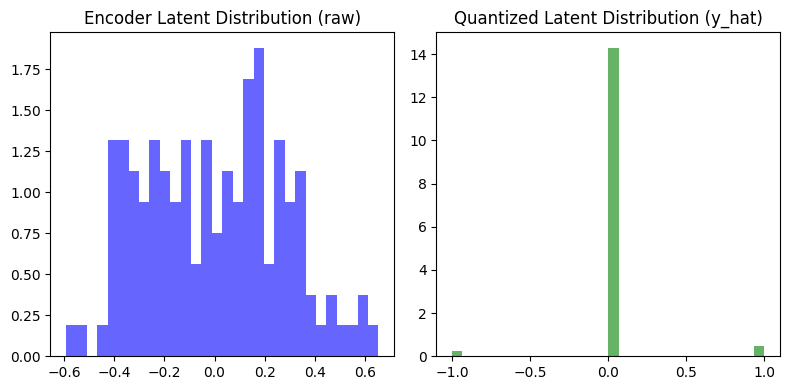

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Suppose you have a trained model
model.eval()

# 1. Create or load a sample test batch
#    Here, just do the same random synthetic data
test_inputs = torch.randn(1, 1, 28, 28, device=device) * 0.1 + 0.5
test_inputs = torch.clamp(test_inputs, 0.0, 1.0)

# 2. Pass it through the encoder
with torch.no_grad():
    latent = model.encoder(test_inputs)  # shape [1, latent_dim]
    latent_reshaped = latent.view(latent.size(0), model.latent_dim, 1, 1)

# 3. Let's get the "noise" or "dequantized" output from the EntropyBottleneck
#    plus the likelihood the bottleneck assigns to that output.
#    (Note: turn off training mode, so we get "dequantize" instead of noise)
model.entropy_bottleneck.eval()
with torch.no_grad():
    y_hat, y_likelihoods = model.entropy_bottleneck(latent_reshaped, training=False)

# Flatten for convenience
# shape [1, latent_dim, 1, 1] -> [latent_dim]
latents_np = latent_reshaped.cpu().view(-1).numpy()
y_hat_np = y_hat.cpu().view(-1).numpy()
likelihoods_np = y_likelihoods.cpu().view(-1).numpy()

# 4. Plot the histogram of the raw latents or the y_hat
plt.figure(figsize=(8, 4))

plt.subplot(1,2,1)
plt.hist(latents_np, bins=30, density=True, alpha=0.6, color='b')
plt.title("Encoder Latent Distribution (raw)")

plt.subplot(1,2,2)
plt.hist(y_hat_np, bins=30, density=True, alpha=0.6, color='g')
plt.title("Quantized Latent Distribution (y_hat)")

plt.tight_layout()
plt.show()

# Optionally, you can also examine 'likelihoods_np' to see how likely
# each quantized value was under the learned distribution.


In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from compressai.entropy_models import EntropyBottleneck
from torchvision.transforms import functional as TF
from PIL import Image, ImageDraw
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from compressai.models import CompressionModel
# Define the Improved Compression Model
class CompressionModel1(CompressionModel):
    def __init__(self, latent_dim=128, num_groups=32):
        super(CompressionModel1, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            # First Convolutional Block
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # [1,28,28] -> [64,14,14]
            nn.GroupNorm(num_groups, 64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Second Convolutional Block with Residual Connection
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # [64,14,14] -> [128,7,7]
            nn.GroupNorm(num_groups, 128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Third Convolutional Block
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # [128,7,7] -> [128,7,7]
            nn.GroupNorm(num_groups, 128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Flatten(),  # [128,7,7] -> [6272]
            nn.Linear(128 * 7 * 7, latent_dim),  # [6272] -> [128]
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Entropy Bottleneck for the latent vector
        self.entropy_bottleneck = EntropyBottleneck(channels=latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),  # [128] -> [6272]
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (128, 7, 7)),  # [6272] -> [128,7,7]
            
            # First Transposed Convolutional Block
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),  # [128,7,7] -> [128,7,7]
            nn.GroupNorm(num_groups, 128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Second Transposed Convolutional Block
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # [128,7,7] -> [64,14,14]
            nn.GroupNorm(num_groups, 64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Third Transposed Convolutional Block
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1),  # [64,14,14] -> [64,14,14]
            nn.GroupNorm(num_groups, 64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Final Transposed Convolution to reconstruct the image
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),  # [64,14,14] -> [1,28,28]
            nn.Sigmoid()  # Ensures output is in [0,1]
        )
        
        self.to(device)  # Ensure the model is on the correct device

    def forward(self, x, use_compression=False):
        """If use_compression=True, we do actual compress->decompress 
        to measure bit-stream size and get y_hat.
        Otherwise, the standard noise/dequant approach is used."""
        latent = self.encoder(x)
        # [B, latent_dim] -> [B, latent_dim, 1, 1]
        latent_reshaped = latent.view(-1, self.latent_dim, 1, 1)
        
        if use_compression:
            # (A) Actual compression to get byte-strings
            # compress() returns a list of bitstreams, one per sample in the batch
            y_strings = self.entropy_bottleneck.compress(latent_reshaped)

            # (B) Decompress
            # We need the shape for decompress. It's everything but the batch dimension
            # e.g. (channels=latent_dim, H=1, W=1).
            out_shape = (self.latent_dim, 1, 1)
            y_hat_list = []
            for s in y_strings:
                # Each s is a single sample's bitstream
                y_hat_i = self.entropy_bottleneck.decompress([s], out_shape)  
                y_hat_list.append(y_hat_i)
            # Concatenate all samples back
            y_hat = torch.cat(y_hat_list, dim=0)
            
            # We can measure real bits as len(s) * 8 for each sample
            # if we want total bits for the entire batch, sum them:
            total_bits = sum(len(stream) * 8 for stream in y_strings)
            # (Just for demonstration, you might prefer returning it)
            
            # Flatten for the decoder
            y_hat = y_hat.view(-1, self.latent_dim)
            # In this scenario, y_likelihoods is not used because we use real cdf.
            _, y_likelihoods = self.entropy_bottleneck(latent_reshaped)
        else:
            # The default path, using noise/dequant approximation
            y_hat, y_likelihoods = self.entropy_bottleneck(latent_reshaped)
            y_hat = y_hat.view(-1, self.latent_dim)

        # Decode
        reconstruction = self.decoder(y_hat)
        return y_hat, reconstruction, y_likelihoods



import torch
import torch.nn as nn

# Corrected Residual Block with Squeeze-and-Excitation
class ResidualSEBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, reduction=16, num_groups=8):
        super(ResidualSEBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(num_groups, out_channels)
        self.activation = nn.SiLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.gn2 = nn.GroupNorm(num_groups, out_channels)
        
        # Squeeze-and-Excitation
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // reduction, kernel_size=1, bias=False),
            nn.SiLU(inplace=True),
            nn.Conv2d(out_channels // reduction, out_channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )
        
        # Skip connection
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                          stride=stride, bias=False),
                nn.GroupNorm(num_groups, out_channels)
            )
        else:
            self.skip = nn.Identity()
    
    def forward(self, x):
        identity = self.skip(x)
        
        out = self.conv1(x)
        out = self.gn1(out)
        out = self.activation(out)
        
        out = self.conv2(out)
        out = self.gn2(out)
        
        # Correct SE scaling
        se_weight = self.se(out)
        out = out * se_weight  # Element-wise multiplication
        
        out += identity
        out = self.activation(out)
        return out


# Define the Self-Attention Block
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        batch, C, H, W = x.size()
        proj_query = self.query(x).view(batch, -1, H * W).permute(0, 2, 1)  # B x N x C'
        proj_key = self.key(x).view(batch, -1, H * W)  # B x C' x N
        energy = torch.bmm(proj_query, proj_key)  # B x N x N
        attention = self.softmax(energy)  # B x N x N
        proj_value = self.value(x).view(batch, C, -1)  # B x C x N
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))  # B x C x N
        out = out.view(batch, C, H, W)
        out = self.gamma * out + x
        return out

# Define the Improved Compression Model
class CompressionModel2(nn.Module):
    def __init__(self, latent_dim=128, num_groups=8):
        super(CompressionModel2, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),  # [1,28,28] -> [64,14,14]
            nn.GroupNorm(num_groups, 64),
            nn.SiLU(inplace=True),
            
            ResidualSEBlock(64, 128, stride=2),  # [64,14,14] -> [128,7,7]
            SelfAttention(128),  # Attention on [128,7,7]
            
            nn.Flatten(),  # [128,7,7] -> [6272]
            nn.Linear(128 * 7 * 7, latent_dim),
            nn.SiLU(inplace=True)
        )
        
        # Entropy Bottleneck for the latent vector
        self.entropy_bottleneck = EntropyBottleneck(channels=latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.SiLU(inplace=True),
            nn.Unflatten(1, (128, 7, 7)),
            
            SelfAttention(128),
            ResidualSEBlock(128, 64, stride=1),  # [128,7,7] -> [64,7,7]
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # [64,7,7] -> [64,14,14]
            nn.GroupNorm(num_groups, 64),
            nn.SiLU(inplace=True),
            
            ResidualSEBlock(64, 64, stride=1),  # [64,14,14] -> [64,14,14]
            SelfAttention(64),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # [64,14,14] -> [1,28,28]
            nn.Sigmoid()  # Ensures output is in [0,1]
        )
        
        self.to_device()
    
    def to_device(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
    
    def forward(self, x):
        device = x.device
        # Encode the input
        latent = self.encoder(x)  # [batch_size, 128]
        
        # Reshape latent for entropy model: [batch_size, 128, 1, 1]
        latent_reshaped = latent.view(latent.size(0), self.latent_dim, 1, 1)
        
        # Pass through entropy bottleneck
        y_hat, y_likelihoods = self.entropy_bottleneck(latent_reshaped)
        
        # Flatten back to [batch_size, 128]
        y_hat = y_hat.view(y_hat.size(0), self.latent_dim)
        
        # Decode the latent representation
        reconstruction = self.decoder(y_hat)  # [batch_size, 1, 28, 28]
        
        return y_hat, reconstruction, y_likelihoods



# Define the Rate-Distortion Loss using CompressAI's EntropyBottleneck
def rate_distortion_loss(y_likelihoods, reconstruction, original, lambda_rd=1.0):
    """
    Computes the combined rate-distortion loss.

    Args:
        y_likelihoods (Tensor): Likelihoods from EntropyBottleneck, shape [batch_size, latent_dim, 1, 1]
        reconstruction (Tensor): Reconstructed data from the decoder, shape [batch_size, 1, 28, 28]
        original (Tensor): Original input data, shape [batch_size, 1, 28, 28]
        lambda_rd (float): Weighting factor between rate and distortion.

    Returns:
        loss (Tensor): Combined loss.
        rate (Tensor): Rate loss (bits per pixel).
        distortion (Tensor): Distortion loss (MSE).
    """
    batch_size = y_likelihoods.size(0)
    num_pixels = original.size(0) * original.size(2) * original.size(3)  # batch_size * 28 * 28

    # Compute rate: sum of negative log2 likelihoods
    # y_likelihoods are the probabilities p(y_hat)
    rate = -torch.log2(y_likelihoods + 1e-10).sum() / num_pixels  # Added epsilon to prevent log(0)

    # Compute distortion: Mean Squared Error
    distortion = F.mse_loss(reconstruction, original)

    # Combined loss
    loss = lambda_rd * distortion + rate
    return loss, rate, distortion

# Function to generate synthetic images with simple geometric shapes
def generate_synthetic_images(batch_size, image_size=(28, 28)):
    images = []
    for _ in range(batch_size):
        # Create a blank grayscale image
        img = Image.new('L', image_size, color=128)  # Mid-gray background
        draw = ImageDraw.Draw(img)
        
        # Randomly decide the number of shapes to draw
        num_shapes = np.random.randint(1, 6)  # 1 to 3 shapes
        
        for _ in range(num_shapes):
            shape_type = np.random.choice(['circle', 'square'])
            # Random position and size
            x0 = np.random.randint(0, image_size[0] // 2)
            y0 = np.random.randint(0, image_size[1] // 2)
            x1 = np.random.randint(image_size[0] // 2, image_size[0])
            y1 = np.random.randint(image_size[1] // 2, image_size[1])
            fill_color = np.random.randint(0, 256)
            
            if shape_type == 'circle':
                draw.ellipse([x0, y0, x1, y1], fill=fill_color)
            else:
                draw.rectangle([x0, y0, x1, y1], fill=fill_color)
        
        # Convert to tensor and normalize to [0,1]
        img_tensor = TF.to_tensor(img).float()
        
        # Add Gaussian noise
        noise = torch.randn_like(img_tensor) * 0.05  # Adjust noise level as needed
        img_tensor = img_tensor + noise
        img_tensor = torch.clamp(img_tensor, 0.0, 1.0)
        
        images.append(img_tensor)
    
    batch = torch.stack(images, dim=0)  # Shape: [batch_size, 1, 28, 28]
    return batch

# Initialize the model and optimizer
latent_dim = 1024
lambda_rd = 1000.0
learning_rate = 8e-4

model = CompressionModel1(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training parameters
num_epochs = 100
batch_size = 4
input_size = (1, 28, 28)  # Grayscale images of size 28x28

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_rate = 0.0
    epoch_distortion = 0.0
    num_batches = 100  # Number of batches per epoch

    for _ in range(num_batches):
        # Generate synthetic images with shapes and noise
        inputs = generate_synthetic_images(batch_size, image_size=(28, 28)).to(device)

        optimizer.zero_grad()

        # Forward pass
        y_hat, reconstruction, y_likelihoods = model(inputs)

        # Compute loss
        loss, rate, distortion = rate_distortion_loss(y_likelihoods, reconstruction, inputs, lambda_rd)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate losses
        epoch_loss += loss.item()
        epoch_rate += rate.item()
        epoch_distortion += distortion.item()

    # Average losses over batches
    avg_loss = epoch_loss / num_batches
    avg_rate = epoch_rate / num_batches
    avg_distortion = epoch_distortion / num_batches

    if (epoch + 1) % 1 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f} | Rate: {avg_rate:.4f} | Distortion: {avg_distortion:.4f}")

print("Training Completed.")


Epoch [1/100] - Loss: 51.1659 | Rate: 6.4847 | Distortion: 0.0447
Epoch [2/100] - Loss: 40.3207 | Rate: 5.4112 | Distortion: 0.0349
Epoch [3/100] - Loss: 26.1214 | Rate: 4.7107 | Distortion: 0.0214
Epoch [4/100] - Loss: 21.2910 | Rate: 4.1113 | Distortion: 0.0172
Epoch [5/100] - Loss: 18.9478 | Rate: 3.5109 | Distortion: 0.0154
Epoch [6/100] - Loss: 16.6796 | Rate: 2.9043 | Distortion: 0.0138
Epoch [7/100] - Loss: 15.2315 | Rate: 2.4403 | Distortion: 0.0128
Epoch [8/100] - Loss: 14.6303 | Rate: 2.1302 | Distortion: 0.0125
Epoch [9/100] - Loss: 14.2362 | Rate: 1.9439 | Distortion: 0.0123
Epoch [10/100] - Loss: 13.2228 | Rate: 1.6938 | Distortion: 0.0115
Epoch [11/100] - Loss: 12.7744 | Rate: 1.5670 | Distortion: 0.0112
Epoch [12/100] - Loss: 12.3902 | Rate: 1.4218 | Distortion: 0.0110
Epoch [13/100] - Loss: 12.4640 | Rate: 1.3721 | Distortion: 0.0111
Epoch [14/100] - Loss: 12.8615 | Rate: 1.3689 | Distortion: 0.0115
Epoch [15/100] - Loss: 11.9157 | Rate: 1.2723 | Distortion: 0.0106
Epoc

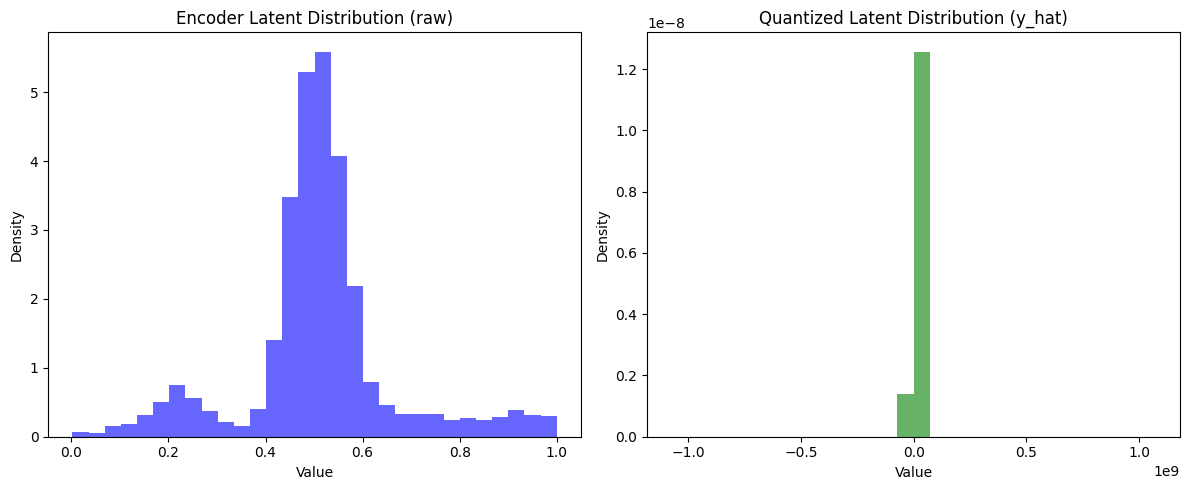

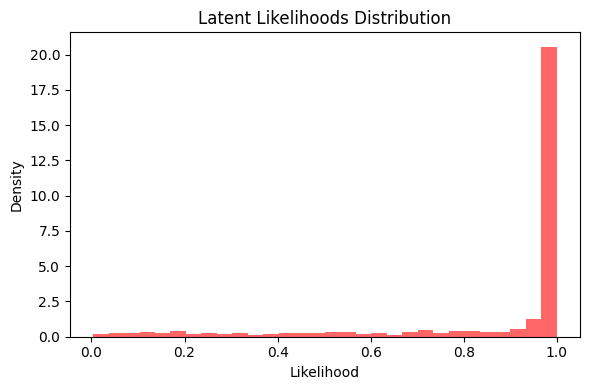

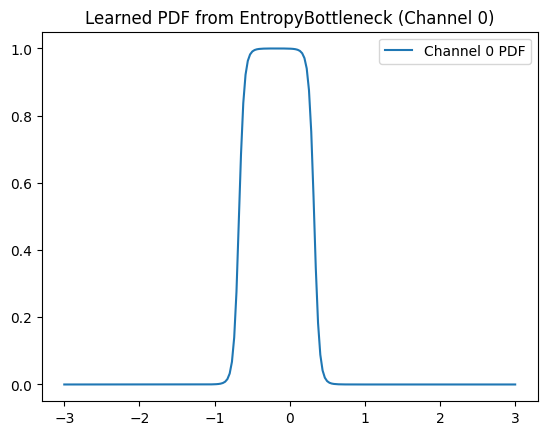

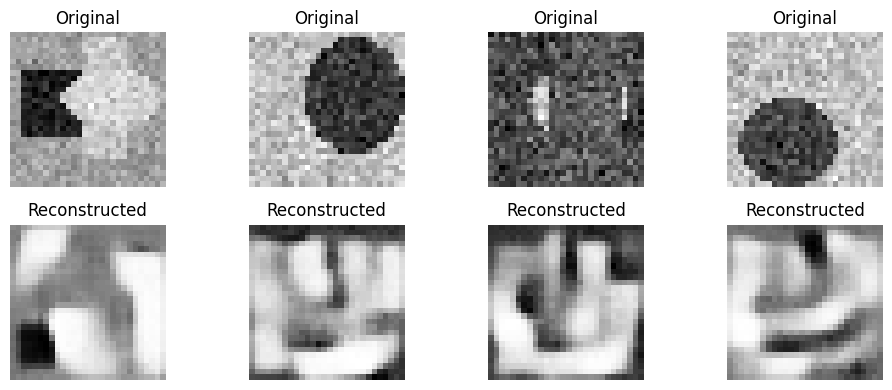

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from PIL import Image, ImageDraw
import torch

# Ensure the generate_synthetic_images function is available
def generate_synthetic_images(batch_size, image_size=(28, 28)):
    images = []
    for _ in range(batch_size):
        # Create a blank grayscale image
        img = Image.new('L', image_size, color=128)  # Mid-gray background
        draw = ImageDraw.Draw(img)
        
        # Randomly decide the number of shapes to draw
        num_shapes = np.random.randint(1, 4)  # 1 to 3 shapes
        
        for _ in range(num_shapes):
            shape_type = np.random.choice(['circle', 'square'])
            # Random position and size
            x0 = np.random.randint(0, image_size[0] // 2)
            y0 = np.random.randint(0, image_size[1] // 2)
            x1 = np.random.randint(image_size[0] // 2, image_size[0])
            y1 = np.random.randint(image_size[1] // 2, image_size[1])
            fill_color = np.random.randint(0, 256)
            
            if shape_type == 'circle':
                draw.ellipse([x0, y0, x1, y1], fill=fill_color)
            else:
                draw.rectangle([x0, y0, x1, y1], fill=fill_color)
        
        # Convert to tensor and normalize to [0,1]
        img_tensor = TF.to_tensor(img).float()
        
        # Add Gaussian noise
        noise = torch.randn_like(img_tensor) * 0.05  # Adjust noise level as needed
        img_tensor = img_tensor + noise
        img_tensor = torch.clamp(img_tensor, 0.0, 1.0)
        
        images.append(img_tensor)
    
    batch = torch.stack(images, dim=0)  # Shape: [batch_size, 1, 28, 28]
    return batch

model.update()
# Suppose you have a trained model
model.eval()

# Function to visualize original and reconstructed images
def visualize_reconstruction(original, reconstruction, num_images=5):
    original = original.cpu().numpy()
    reconstruction = reconstruction.cpu().detach().numpy()
    
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Original Image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i, 0], cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        # Reconstructed Image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstruction[i, 0], cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 1. Create a sample test batch using the synthetic image generator
test_batch_size = 8  # You can adjust the number of test samples
test_inputs = generate_synthetic_images(test_batch_size, image_size=(28, 28)).to(device)

# 2. Pass the test batch through the model
with torch.no_grad():
    y_hat, reconstruction, y_likelihoods = model(test_inputs, use_compression=True)

# 3. Extract latent representations and likelihoods
latent_reshaped = y_hat.view(y_hat.size(0), model.latent_dim, 1, 1)

# Flatten for convenience
latents_np = test_inputs.cpu().view(-1).numpy()  # Original inputs
y_hat_np = y_hat.cpu().view(-1).numpy()        # Quantized latents
likelihoods_np = y_likelihoods.detach().cpu().view(-1).numpy()  # Likelihoods

# 4. Plot the histogram of the raw latents (encoder outputs) and y_hat (quantized latents)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(test_inputs.cpu().view(-1).numpy(), bins=30, density=True, alpha=0.6, color='b')
plt.title("Encoder Latent Distribution (raw)")
plt.xlabel("Value")
plt.ylabel("Density")

plt.subplot(1, 2, 2)
plt.hist(y_hat_np, bins=30, density=True, alpha=0.6, color='g')
plt.title("Quantized Latent Distribution (y_hat)")
plt.xlabel("Value")
plt.ylabel("Density")

plt.tight_layout()
plt.show()

# 5. Optionally, plot the likelihoods
plt.figure(figsize=(6, 4))
plt.hist(likelihoods_np, bins=30, density=True, alpha=0.6, color='r')
plt.title("Latent Likelihoods Distribution")
plt.xlabel("Likelihood")
plt.ylabel("Density")
plt.tight_layout()
plt.show()
# Let's pick channel c=0 for illustration
c = 0
# Choose some grid of values around [-3, 3] or whatever range
grid = torch.linspace(-3, 3, steps=200).to(device)
grid = grid.view(-1, 1, 1, 1)  # shape [200,1,1,1]

# We'll feed "grid" to the internal _likelihood call to see what "pdf" it assigns
# This is an internal function, so expect to do a bit of hacking:
with torch.no_grad():
    # We only want channel c, so we could slice or pass the entire shape
    # but let's do a small shape [1, grid.shape[0], 1, 1]
    # Then manually index channel 0 if needed. For demonstration:
    pdf_vals, _, _ = model.entropy_bottleneck._likelihood(grid, stop_gradient=True)
    pdf_vals = pdf_vals[:, 0, 0, 0].cpu().numpy()
    x_axis = grid[:, 0, 0, 0].cpu(
        
    ).numpy()

plt.figure()
plt.plot(x_axis, pdf_vals, label=f"Channel {c} PDF")
plt.legend()
plt.title("Learned PDF from EntropyBottleneck (Channel 0)")
plt.show()

# 6. Visualize some original and reconstructed images
visualize_reconstruction(test_inputs, reconstruction, num_images=4)


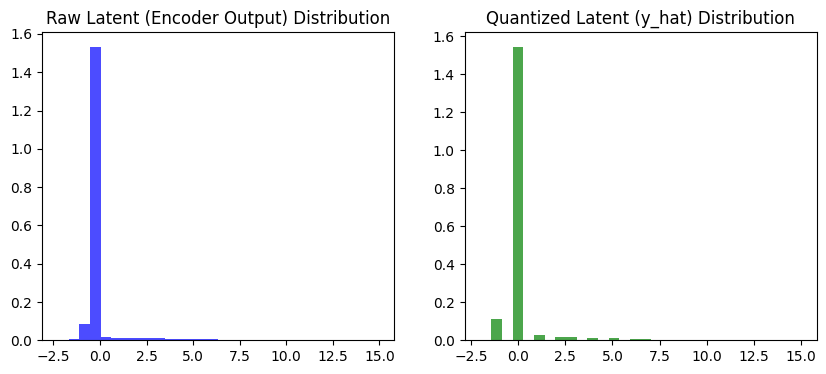

In [74]:
# 2) Encode & pass through EntropyBottleneck
with torch.no_grad():
    latent = model.encoder(test_inputs)
    latent_reshaped = latent.view(latent.size(0), model.latent_dim, 1, 1)
    y_hat, y_likelihoods = model.entropy_bottleneck(latent_reshaped, training=False)

# 3) Flatten and histogram
latents_np = latent_reshaped.cpu().view(-1).numpy()
y_hat_np = y_hat.cpu().view(-1).numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(latents_np, bins=30, density=True, color='b', alpha=0.7)
plt.title("Raw Latent (Encoder Output) Distribution")

plt.subplot(1,2,2)
plt.hist(y_hat_np, bins=30, density=True, color='g', alpha=0.7)
plt.title("Quantized Latent (y_hat) Distribution")

plt.show()


In [77]:
model.entropy_bottleneck._quantized_cdf.shape

torch.Size([1024, 23])